In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.6 MB/s eta 0:00:00


In [ ]:
pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=f56a3304e7baeb2f7b1d87146af65234916714c318ad35384dfcb910c88863f7
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
pip install requests_html

# Creating Covariance Matrix Using Historical Data

In order to create mock returns for the past 100 years, I've taken the average return(given in paper) and created a normal distribution for each asset, and then created a corrosponding covariance matrix using these mock returns.

In [ ]:
import pandas as pd
import numpy as np

# Mock historical daily returns for 3 assets (in percentages)
data = {
    'Endesa': np.random.normal(-0.051, 0.5, 100),  # Mock returns centered around -0.051% (given as average returns of Endesa in paper) with some standard deviation
    'Repsol': np.random.normal(0.036, 0.5, 100),   # Mock returns centered around 0.036% (Repsol)
    'Iberdrola': np.random.normal(-0.022, 0.5, 100),  # Mock returns centered around -0.022% (Iberdrola)
}

# Convert to DataFrame
returns = pd.DataFrame(data)

# Calculate covariance matrix of these returns
covariance_matrix = returns.cov()

print(covariance_matrix)

             Endesa    Repsol  Iberdrola
Endesa     0.214773 -0.035992   0.023700
Repsol    -0.035992  0.246535   0.024064
Iberdrola  0.023700  0.024064   0.275875


# Creating A Logarithmic Objective Function

Using a Logarithmic Objective Function, I've taken what was given in the paper, i.e. these parts:


1. ESG scores for the three companies respectively
esg_scores = np.array([8.7, 7.32, 8.97])

2. Average returns for the three companies
average_returns = np.array([-0.051, 0.036, -0.022]) / 100
3. Risk-free rate
risk_free_rate = 1.2 / 100  
4. Sharpe Ratio bounds: sharpe_max = 3 sharpe_min = -60

Some assumptions I've taken was that the minimum amount to be invested in any of the three assets to be at least 10% of the total amount, since this adds some level of complexity to the objective function. Also, in the paper they use UCB (upper confidence bound) acquisition function so as to maximize the returns, so I've taken the negative of the objective function and used LCB (lower confidence bound) as the acquisition function. This mimics the UCB acquisition since UCB wasn't available on SkOpt.



Optimal weights: [0.09944796912452918, 0.6838001574154836, 0.21675187345998717]
Maximum objective value (log((normalized_sharpe_ratio - portfolio_esg_score)**4)): -7.079670478413071


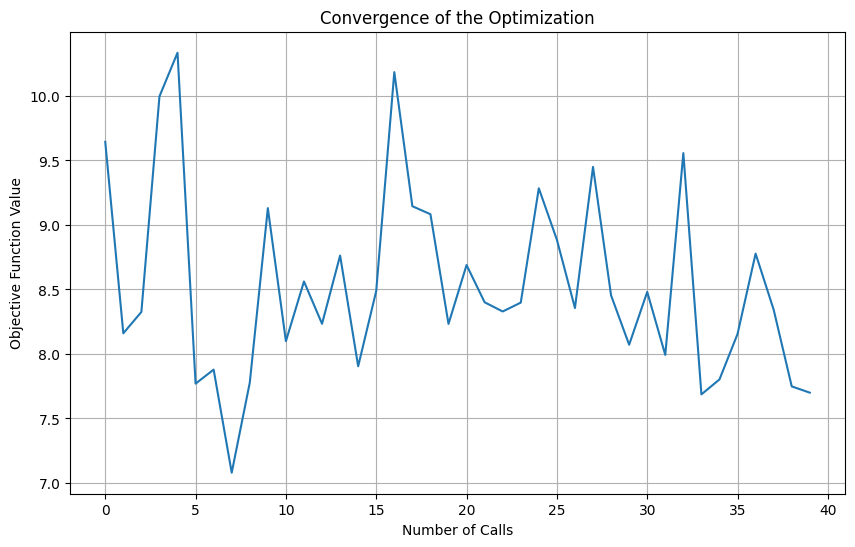

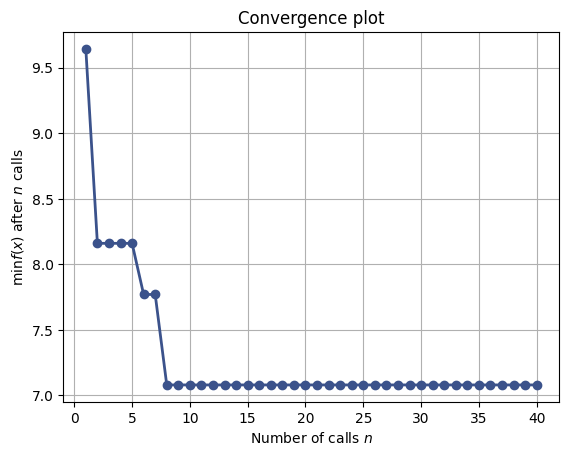

ValueError: shapes (3,100,100) and (3,) not aligned: 100 (dim 2) != 3 (dim 0)

In [ ]:
 from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skopt.plots import plot_convergence

# Mimic historical daily returns for 3 assets (in percentages)
data = {
    'Endesa': np.random.normal(-0.051, 0.5, 100),
    'Repsol': np.random.normal(0.036, 0.5, 100),
    'Iberdrola': np.random.normal(-0.022, 0.5, 100),
}

# Convert to DataFrame and calculate covariance matrix
historic_returns = pd.DataFrame(data)
covariance_matrix = historic_returns.cov().values  # Convert to numpy array for matrix operations

N = 3  # Number of companies
# Define the bounds for each weight variable
weight_space = [Real(0.1, 1, name=f'weight_{i}') for i in range(N)]


# ESG scores for the three companies respectively
esg_scores = np.array([8.7, 7.32, 8.97])

# Average returns for the three companies
average_returns = np.array([-0.051, 0.036, -0.022]) / 100  # Convert percentages to decimals

# Risk-free rate
risk_free_rate = 1.2 / 100  # Convert percentage to decimal

# Sharpe Ratio bounds (given)
sharpe_max = 3
sharpe_min = -60

@use_named_args(weight_space)
def objective(**kwargs):
    w = np.array([kwargs[f'weight_{i}'] for i in range(N)])
    epsilon = 1e-8  # Small value to avoid division by zero
    w /= (np.sum(w) + epsilon)  # Normalize weights with epsilon to avoid division by zero

    # Calculate the portfolio's expected return
    R_p = np.dot(w, average_returns)

    # Calculate portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(w.T, np.dot(covariance_matrix, w))

    # Ensure portfolio variance is always positive to avoid sqrt of negative number
    portfolio_variance = max(portfolio_variance, epsilon)

    # Calculate Sharpe Ratio, adding epsilon to avoid division by zero
    sharpe_ratio = (R_p - risk_free_rate) / np.sqrt(portfolio_variance)

    # Normalize Sharpe Ratio
    normalized_sharpe_ratio = (sharpe_ratio - sharpe_min) / (sharpe_max - sharpe_min)

    # Calculate weighted ESG score
    portfolio_esg_score = np.dot(w, esg_scores) / 10  # Normalize ESG scores to be between 0 and 1

    # Objective combines normalized Sharpe Ratio and penalizes by ESG score
    objective_value = np.log((normalized_sharpe_ratio - portfolio_esg_score)**4)

    return -objective_value  # Minimize negative objective for maximization

# Perform Bayesian Optimization with UCB acquisition function
result = gp_minimize(objective,
                     dimensions=weight_space,
                     acq_func="LCB",
                     kappa=10,  # Confidence level parameter for UCB, increasing kappa to encourage exploration
                     n_calls=40,
                     n_initial_points=40,
                     random_state=42)

# Extract optimal weights and display results
optimal_weights = [result.x[i] for i in range(N)]

# Normalize to ensure weights sum up to 1
sum_weights = sum(optimal_weights)
optimal_weights_normalized = [w / sum_weights for w in optimal_weights]

print(f"Optimal weights: {optimal_weights_normalized}")

# Maximum objective value achieved
max_objective_value = -result.fun
print(f"Maximum objective value (log((normalized_sharpe_ratio - portfolio_esg_score)**4)): {max_objective_value}")

# Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(result.func_vals)
plt.xlabel('Number of Calls')
plt.ylabel('Objective Function Value')
plt.title('Convergence of the Optimization')
plt.grid(True)
plt.show()

bounds = [(0.1, 1), (0.1, 1)]

# Defining a function to plot contours of the objective function
def plot_contours(objective_function, bounds):
    x = np.linspace(bounds[0][0], bounds[0][1], 100)
    y = np.linspace(bounds[1][0], bounds[1][1], 100)
    X, Y = np.meshgrid(x, y)

    # Create an array to hold the objective function values
    Z = np.zeros_like(X)

    # Create a meshgrid for the third weight variable (fixed at 0.5)
    W = np.full_like(X, 0.5)

    # Evaluate the objective function across the meshgrid
    Z = objective_function([X, Y, W])

    # Plotting
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Objective Function Value')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Contour Plot')
    plt.show()


# Plotting convergence using skopt
plot_convergence(result)
plt.show()

# Call the function to plot contours
plot_contours(objective, bounds)
plt.show()


# Benchmarking Against Randomized Search and Plotting Pairwise Contours

Created a new objective function to accept vectorized weights and then plotted pairwise to see the variation visually against each other.

Also made a randomized search algorithm to measure against to check if the values obtained are correct. This is not with Endesa etc. but with the new tickers (WALMART, APPLE, AMAZON AND GOOGLE)- this is for final BTP work.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 1.0, 0.1, 0.1] before, using random point [0.3935177054665625, 0.9861491376962085, 0.818078638526211, 0.592284349087631]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 1.0, 0.1, 0.1] before, using random point [0.7297326540325602, 0.9022367324648803, 0.39670539482943357, 0.5498549035112601]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1, 1.0, 0.1, 0.1] before, using random poin

Optimal weights: [0.1, 1.0, 0.1, 0.1]
Maximum objective value: 9.05673917739262


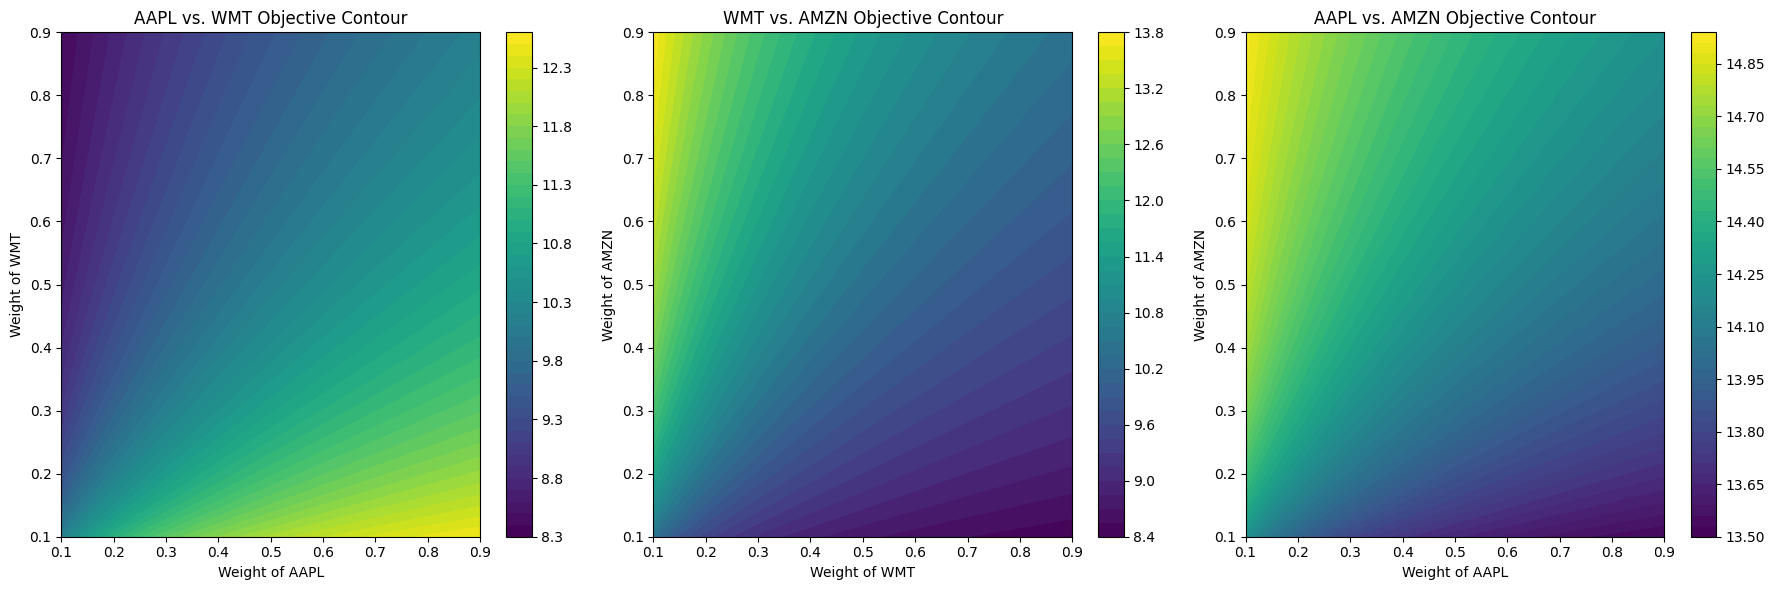

Best weights from randomized search: [0.19082092 0.68996083 0.04383496 0.07538329]
Best score from randomized search: 9.394067579677868


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real
import yfinance as yf

tickers = ['AAPL', 'WMT', 'AMZN', 'GOOGL']

# Fetching historical daily returns for the tickers
data = {ticker: yf.download(ticker, start='2023-01-01', end='2024-01-01')['Adj Close'].pct_change().dropna().values for ticker in tickers}

# Converting to DataFrame and calculate covariance matrix
historic_returns = pd.DataFrame(data)
covariance_matrix = historic_returns.cov().values

esg_scores = np.array([8.7, 7.32, 8.97, 9.1])
average_returns = np.array([historic_returns[ticker].mean() for ticker in tickers])
risk_free_rate = 1.2 / 100
sharpe_max = 3
sharpe_min = -60

# Direct list of weights
def objective(weights):
    w = np.array(weights)
    w /= np.sum(w)

    # Calculate the portfolio's expected return
    R_p = np.dot(w, average_returns)
    # Calculate portfolio variance using the covariance matrix
    portfolio_variance = np.dot(w.T, np.dot(covariance_matrix, w))
    # Ensure portfolio variance is always positive to avoid sqrt of negative number
    sharpe_ratio = (R_p - risk_free_rate) / np.sqrt(max(portfolio_variance, 1e-8))
    # Calculate Sharpe Ratio, adding epsilon to avoid division by 0
    normalized_sharpe_ratio = (sharpe_ratio - sharpe_min) / (sharpe_max - sharpe_min)
    # Calculate weighted ESG score
    portfolio_esg_score = np.dot(w, esg_scores) / 10 # Normalize ESG score between 0,1
    # Objective combines normalized Sharpe Ratio and penalizes by ESG score
    objective_value = np.log((normalized_sharpe_ratio - portfolio_esg_score)**5 + 1e-8)
    return -objective_value # Minimize objective function for maximization

# Bayesian Optimization with adjusted objective function call , UCB acquisition still
dimensions = [Real(0.1, 1) for _ in range(4)]
result = gp_minimize(lambda x: objective(x),
                     dimensions=dimensions,
                     acq_func="LCB",
                     kappa=10,
                     n_calls=80,
                     n_initial_points=40,
                     random_state=42)

# Extract Optimal weights and display results
print(f"Optimal weights: {result.x}")
print(f"Maximum objective value: {result.fun}")

# Plotting function adjusted for the re-defined objective
def plot_pairwise_contours_adjusted(objective, resolution=50):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    names = tickers
    combinations = [(0, 1), (1, 2), (0, 2), (2, 3)]  # Pairwise combinations of the weights

    for idx, (ax, (i, j)) in enumerate(zip(axes, combinations)):
        x = np.linspace(0.1, 0.9, resolution)
        y = np.linspace(0.1, 0.9, resolution)
        X, Y = np.meshgrid(x, y)

        # Calculate the dependent weight as 1 - x - y - z to ensure all weights sum to 1
        # This dependent weight will be for the asset not being directly compared in this subplot
        Z = 1 - X - Y

        # Create an array of zeros for Z values
        Z = np.zeros_like(X)

        # Calculate the objective function value for each combination of X, Y, Z
        for m in range(resolution):
            for n in range(resolution):
                # Preparing the weights array based on the current combination
                weights = np.zeros(4)
                weights[i], weights[j] = X[m, n], Y[m, n]
                weights[3 - i - j] = Z[m, n]  # The third weight is the dependent one

                # Ensuring the dependent weight is within bounds
                if weights[3 - i - j] >= 0 and np.all(weights <= 1):
                    Z[m, n] = objective(weights)
                else:
                    Z[m, n] = np.nan  # Assign NaN to out-of-bounds areas

        # Contour plot for the pair of weights
        cs = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
        fig.colorbar(cs, ax=ax)
        ax.set_xlabel(f'Weight of {names[i]}')
        ax.set_ylabel(f'Weight of {names[j]}')
        ax.set_title(f'{names[i]} vs. {names[j]} Objective Contour')

    plt.tight_layout()
    plt.show()

plot_pairwise_contours_adjusted(objective)

# Randomized search
def randomized_search_adjusted(objective_function, bounds, n_iter=100):
    best_score = float('inf')
    best_weights = None

    for _ in range(n_iter):
        # Generate random weights
        raw_weights = np.random.uniform(0, 1, len(bounds))
        # Normalize the weights
        weights = raw_weights / np.sum(raw_weights)

        score = objective_function(weights)

        if score < best_score:
            best_score = score
            best_weights = weights

    return best_weights, best_score

# Ensure objective function is defined to accept a numpy array of weights
best_weights, best_score = randomized_search_adjusted(objective, [(0.1, 0.9) for _ in range(4)], 100)

print("Best weights from randomized search:", best_weights)
print("Best score from randomized search:", best_score)


Backtesting

[*********************100%%**********************]  4 of 4 completed


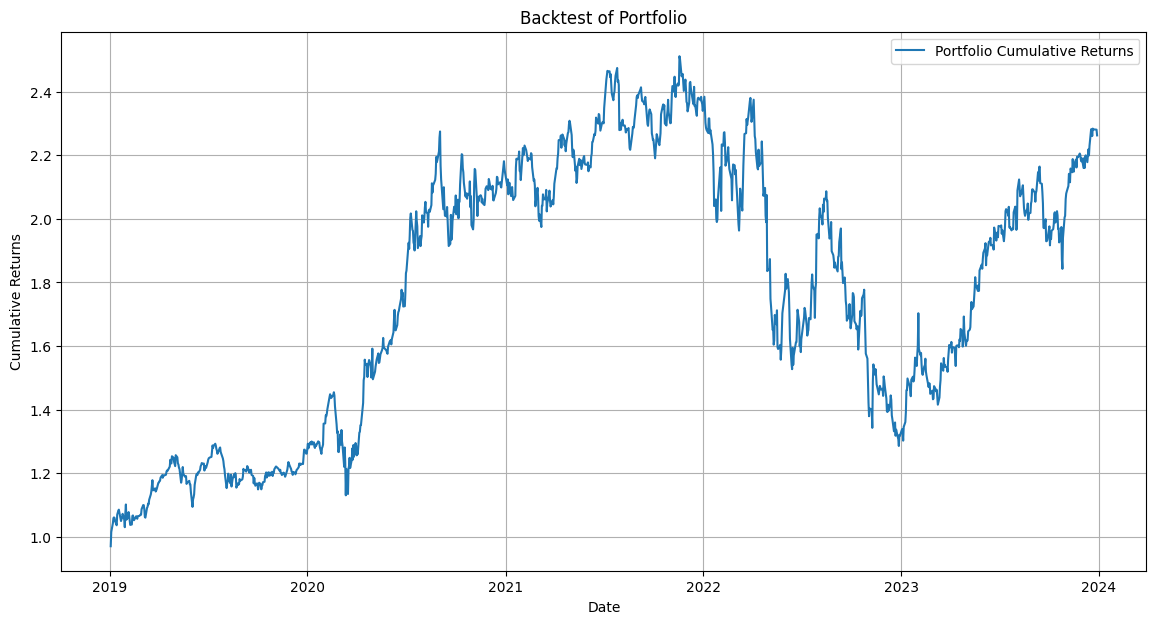

Final Cumulative Return: 2.26
Annualized Return: 17.78%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ['AAPL', 'WMT', 'AMZN', 'GOOGL']
weights = np.array([0.1, 1.0, 0.1, 0.1])  # Final weights

# Normalize weights
weights /= np.sum(weights)

# Downloading historical data for the tickers
start_date = '2019-01-01'
end_date = '2024-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculating daily returns
returns = data.pct_change().dropna()

# Calculating portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Calculating cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Portfolio Cumulative Returns')
plt.title('Backtest of Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Print final cumulative return
final_cumulative_return = cumulative_returns.iloc[-1]
print(f"Final Cumulative Return: {final_cumulative_return:.2f}")

# Calculating annualized return
days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
annualized_return = (final_cumulative_return ** (365/days)) - 1
print(f"Annualized Return: {annualized_return:.2%}")


The maximum score is slightly better in Bay-Opt than Randomized Search. We can continue to adjust the objective function for it to be even better.

to do: plot contour with w3 = 1-w1-w2
